In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam , SGD
import cv2

In [2]:
image_directory = "cell_images/"
size = 224
dataset = []
label = []

In [3]:
parasitized_images = os.listdir(image_directory +"Parasitized/")

In [4]:
for i , image_name in enumerate(parasitized_images):
    if (image_name.split('.')[1]=="png"):
        image = cv2.imread(image_directory + "Parasitized/" + image_name)
        image = Image.fromarray(image , "RGB")
        image = image.resize((size , size))
        dataset.append(np.array(image))
        label.append(1)

In [5]:
uninfected_image = os.listdir(image_directory +"Uninfected/")
for i , image_name in enumerate(uninfected_image):
    if (image_name.split(".")[1] =="png"):
        image = cv2.imread(image_directory + "Uninfected/" + image_name)
        image = Image.fromarray(image , "RGB")
        image = image.resize((size , size))
        dataset.append(np.array(image))
        label.append(0)

In [6]:
dataset = np.array(dataset)
label = np.array(label)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train ,X_test , y_train , y_test = train_test_split(dataset , label , test_size=0.20 , random_state=0)

In [9]:
X_train = X_train / 255.
X_test = X_test / 255.

In [10]:
from tensorflow.keras.utils import to_categorical

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
def model(input_shape = (224,224,3)):
    vgg = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape)
    for layers in vgg.layers[:-5]:
        print(layers)
        layers.trainable=False

    x = vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2 , activation="softmax")(x)

    model = Model(vgg.input , x)
    model.compile(loss="categorical_crossentropy",
                 optimizer=SGD(lr = 0.0001,
                              momentum=0.9),
                 metrics=["accuracy"])
    return model

In [13]:
model = model(input_shape=(224 , 224 , 3))

C:\Users\ankus\anaconda3\envs\new_env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
history = model.fit(X_train , y_train , batch_size=1 , epochs= 20 , verbose=1 , validation_data=(X_test , y_test))

Epoch 1/20
1600/1600 [==============================] - 51s 27ms/step - loss: 0.4380 - accuracy: 0.7900 - val_loss: 0.4903 - val_accuracy: 0.8350
Epoch 2/20
1600/1600 [==============================] - 47s 30ms/step - loss: 0.2269 - accuracy: 0.9194 - val_loss: 0.2461 - val_accuracy: 0.9000
Epoch 3/20
1600/1600 [==============================] - 48s 30ms/step - loss: 0.1926 - accuracy: 0.9306 - val_loss: 0.2518 - val_accuracy: 0.9025
Epoch 4/20
1600/1600 [==============================] - 47s 29ms/step - loss: 0.1865 - accuracy: 0.9356 - val_loss: 0.2215 - val_accuracy: 0.9250
Epoch 5/20
1600/1600 [==============================] - 47s 29ms/step - loss: 0.1657 - accuracy: 0.9406 - val_loss: 0.2246 - val_accuracy: 0.9175
Epoch 6/20
1600/1600 [==============================] - 47s 29ms/step - loss: 0.1550 - accuracy: 0.9450 - val_loss: 0.2074 - val_accuracy: 0.9225
Epoch 7/20
1600/1600 [==============================] - 43s 27ms/step - loss: 0.1473 - accuracy: 0.9494 - val_loss: 0.2244 -

In [16]:
model.save("model.h5")

## loss v/s epochs

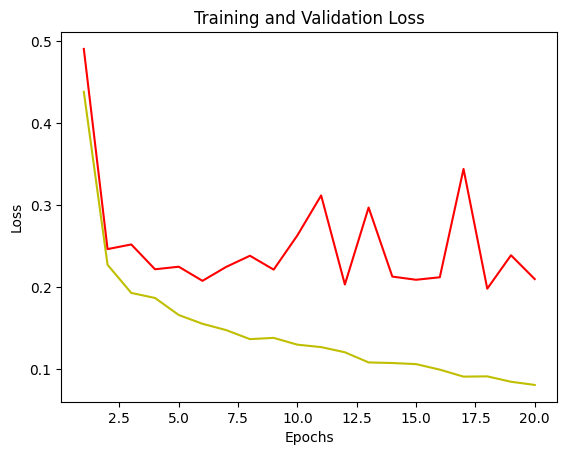

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1 , len(loss) +1)
plt.plot(epochs , loss , 'y' , label = "Training loss")
plt.plot(epochs , val_loss , "r" , label = "validation loss")
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

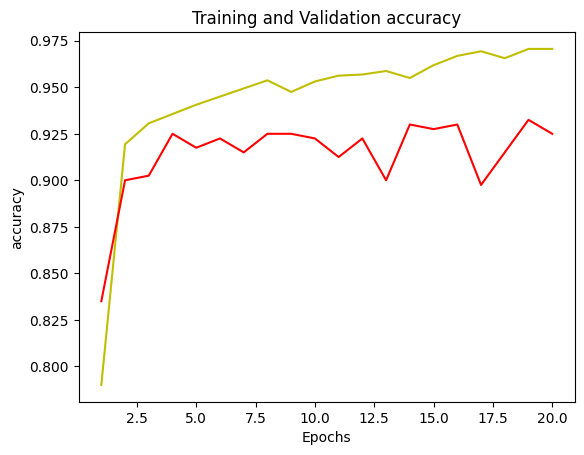

In [23]:
acc = history.history['accuracy']
validation = history.history['val_accuracy']
plt.plot(epochs , acc , 'y' , label = "Training accuracy")
plt.plot(epochs , validation , "r" , label = "validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

In [45]:
parasited_image_idx = np.where(y_pred == 1)[0]
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    

In [49]:
print(predicted_as_para.shape)

(0,)


In [55]:
from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])

    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0

    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

1/1 [==============================] - 0s 230ms/step
0


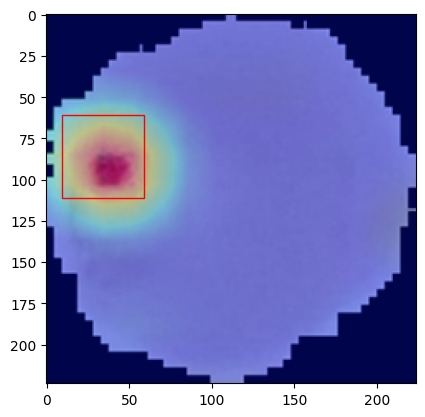

In [56]:
img = cv2.imread("C48P9thinF_IMG_20150721_161243_cell_158.png")
plt.imshow(img)
image = Image.fromarray(img , "RGB")
image = image.resize((size , size))
image = np.array(image)
image = image / 255.
heat_map =plot_heatmap(image)

1/1 [==============================] - 0s 226ms/step
0


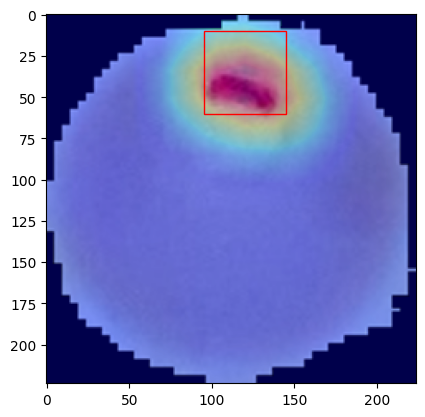

In [58]:
img = cv2.imread("C33P1thinF_IMG_20150619_114756a_cell_181.png")
plt.imshow(img)
image = Image.fromarray(img , "RGB")
image = image.resize((size , size))
image = np.array(image)
image = image / 255.
heat_map =plot_heatmap(image)

1/1 [==============================] - 0s 232ms/step
0


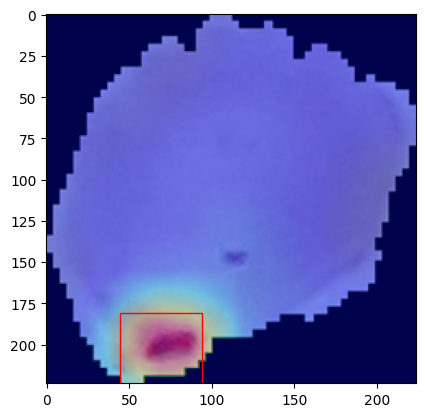

In [59]:
img = cv2.imread("C99P60ThinF_IMG_20150918_141129_cell_146.png")
plt.imshow(img)
image = Image.fromarray(img , "RGB")
image = image.resize((size , size))
image = np.array(image)
image = image / 255.
heat_map =plot_heatmap(image)